In [1]:
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
import os
import numpy as np
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), "./src/"))

Using TensorFlow backend.


In [2]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
my_model = load_model(os.path.join("model_output/" + '5_layers_cnn0.h5'), custom_objects={ 'auc': auc})

In [4]:
#from audio_preprocessing import get_log_mel_madmom
from src.audio_preprocessing import getMFCCBands2DMadmom

In [5]:
wav_jingju = 'wavs/mayu.wav'
log_mel = getMFCCBands2DMadmom(wav_jingju, 44100, 0.01, channel=1)

In [6]:
log_mel = log_mel.reshape(log_mel.shape[0], 80, 15)
log_mel = np.expand_dims(log_mel, axis=1)

In [7]:
from utilFunctions import smooth_obs

In [8]:
pdf=my_model.predict(log_mel, batch_size = 256)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

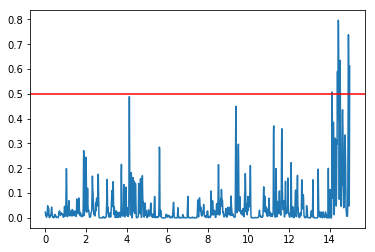

In [10]:
import matplotlib.pyplot as plt
snip = pdf[0: 15*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

In [11]:
from experiment_process_helper import boundary_decoding
from madmom.features.onsets import OnsetPeakPickingProcessor

b_baseline, _ = boundary_decoding(decoding_method="lmao",
                                      obs_i=pdf,
                                      duration_score=None,
                                      varin=None,
                                      threshold=0.5,
                                      hopsize_t=0.01,
                                      viterbiDecoding=None,
                                      OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)

In [12]:
b_baseline.shape

(507,)

In [13]:
lines = []
with open("timings/mayu.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "") for x in lines[3:]]).astype("float")

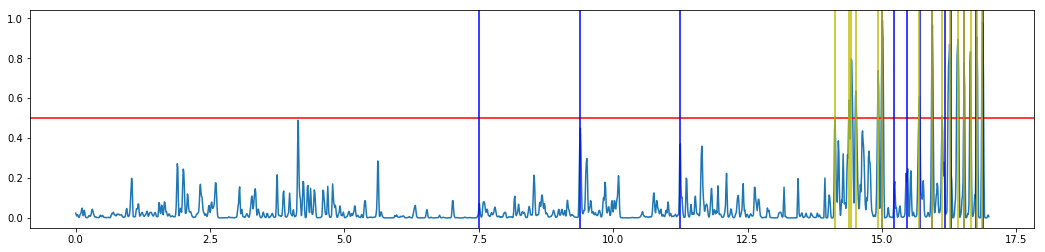

In [14]:
plt.figure(figsize=(18, 4))
length = 17
snip = pdf[0: length*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')

for mark in lines:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'b')
for mark in b_baseline*0.01:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'y')
plt.show()

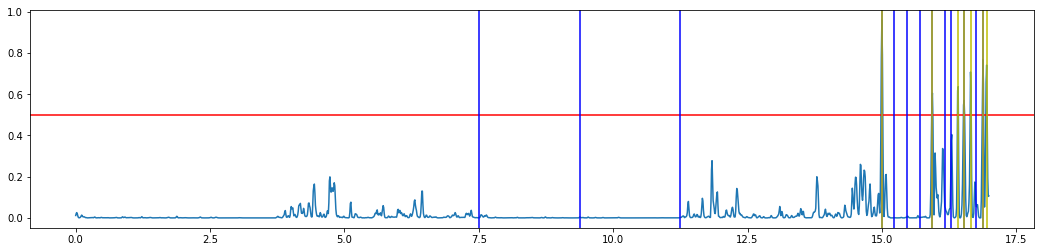

In [16]:
plt.figure(figsize=(18, 4))
length = 17
snip = pdf[0: length*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')

for mark in lines:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'b')
for mark in b_baseline*0.01:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'y')
plt.show()

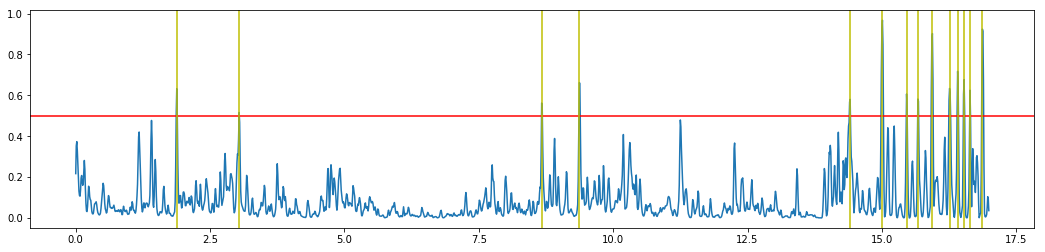

In [27]:
plt.figure(figsize=(18, 4))
length = 17
snip = pdf[0: length*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'y')
plt.show()

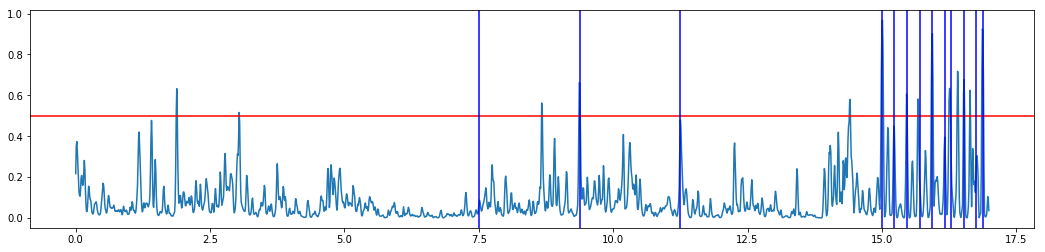

In [40]:
plt.figure(figsize=(18, 4))
length = 17
snip = pdf[0: length*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark > length:
        break
    plt.axvline(x=mark, color= 'b')
plt.show()